In [1]:
!pip install langchain
!pip install google-generativeai
!pip install langchain-community
!pip install langchain_google_genai

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import os
import getpass
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "<api_key>" # Update to your API key
os.environ["LANGCHAIN_PROJECT"] = "Tracing Walkthrough - dceec752" #"travel-planner"

In [2]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage
from langchain import PromptTemplate
from langchain.memory import ChatMessageHistory
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains import SimpleSequentialChain

# Used for by Gemini 1.5 pro
os.environ['GOOGLE_API_KEY'] = '<api_key>'

In [4]:
from datasets import load_dataset
import json
import re
from datetime import datetime
from typing import List, Dict
from collections import Counter, defaultdict
import pandas as pd
import time
import random
import signal
import math
import ast
import matplotlib.pyplot as plt
from Tools import Flights, Restaurants, Attractions, Accommodations, Notebook, GoogleDistanceMatrix, Evaluation

In [5]:
llm1 = GoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2,
    max_tokens=8192,
    timeout=None,
    max_retries=2,
    # other params...
)

In [6]:
llm2 = GoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0.3,
    max_tokens=8192,
    timeout=None,
    max_retries=2,
    # other params...
)

In [7]:
# Load the TravelPlanner dataset
ds = load_dataset("osunlp/TravelPlanner", 'validation')

In [8]:
ds

DatasetDict({
    validation: Dataset({
        features: ['org', 'dest', 'days', 'visiting_city_number', 'date', 'people_number', 'local_constraint', 'budget', 'query', 'level', 'reference_information'],
        num_rows: 180
    })
})

In [9]:
# Extract the first row from the validation set
first_row = ds['validation'][0]
#print(type(first_row))

In [10]:
for key in first_row.keys():
    value = first_row[key]
    print(f"Key: {key}")
    print(f"Value: {value}")
    print(f"Type of Value: {type(value)}")
    print()

Key: org
Value: Washington
Type of Value: <class 'str'>

Key: dest
Value: Myrtle Beach
Type of Value: <class 'str'>

Key: days
Value: 3
Type of Value: <class 'int'>

Key: visiting_city_number
Value: 1
Type of Value: <class 'int'>

Key: date
Value: ['2022-03-13', '2022-03-14', '2022-03-15']
Type of Value: <class 'str'>

Key: people_number
Value: 1
Type of Value: <class 'int'>

Key: local_constraint
Value: {'house rule': None, 'cuisine': None, 'room type': None, 'transportation': None}
Type of Value: <class 'str'>

Key: budget
Value: 1400
Type of Value: <class 'int'>

Key: query
Value: Please create a travel plan for me where I'll be departing from Washington and heading to Myrtle Beach for a 3-day trip from March 13th to March 15th, 2022. Can you help me keep this journey within a budget of $1,400?
Type of Value: <class 'str'>

Key: level
Value: easy
Type of Value: <class 'str'>

Key: reference_information
Value: [{'Description': 'Attractions in Myrtle Beach', 'Content': "              

In [13]:
query = first_row['query']

In [14]:
print(query)

Please create a travel plan for me where I'll be departing from Washington and heading to Myrtle Beach for a 3-day trip from March 13th to March 15th, 2022. Can you help me keep this journey within a budget of $1,400?


In [15]:
dates = ast.literal_eval(first_row['date'])

In [16]:
print(dates)

['2022-03-13', '2022-03-14', '2022-03-15']


In [17]:
local_constraint = ast.literal_eval(first_row['local_constraint'])

In [18]:
local_constraint

{'house rule': None,
 'cuisine': None,
 'room type': None,
 'transportation': 'no flight'}

## Outline Generation Phase

In [19]:
# Long prompt template for the PathFinder Agent

outline_prompt_template = """
You are a proficient planner. Based on the provided information and query, please give me an outline for my
whole trip. Please help me generate an outline for each day of this query, primarily including which city it
involves, whether there's a need to travel from one city to another. Don't include any specific details like flight
numbers, restaurant names, or attraction names. You should use 'The First', 'The Second', 'The Third', etc., to
indicate the order of the days. You shouldn't include any city or state names which are not in the query. In your
outline, only the cities mentioned in the query can appear; absolutely no other cities or state names are
allowed.
Here are some examples:
* Example 1 *
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from
September 21st to September 23rd, 2023, with a budget of $18,500?
Your Outline:
The First Day: from Boston to San Francisco. Exploring San Francisco.
The Second Day: Exploring San Francisco.
The Third Day: from San Francisco to Boston.
* STOP *
* Example 2 *
Query: Could you craft a 5-day journey itinerary for a party of 6? We'll be kicking off in Seattle and aim to
explore 2 cities in California from April 25th to April 29th, 2023. Our budget is roughly $16,500, and we prefer to
book whole places for our lodging.
The cities in California are here: (Omitting the detail list of cities in California in this example.)
Your Outline:
The First Day: from Seattle to San Diego. Exploring San Diego.
The Second Day: Exploring San Diego.
The Third Day: from San Diego to Butte. Exploring San Diego or Butte.
The Fourth Day: Exploring Butte
The Fifth Day: from Butte to Seattle.
* STOP *
* Example 3 *
Query:Could you create a 7-day travel itinerary for two, starting from Seattle and traveling to New York, where
we will explore 3 distinct cities? The journey is planned from July 10th to July 20th, 2023. Our updated budget is
$6,000. For our stays, we're looking for private accommodations. We plan to avoid any air travel for moving
between locations. When it comes to dining, we're eager to try a range of food styles, including Italian, Japanese, Indian, and Thai.
The cities in New York are here: (Omitting the detail list of cities in New York in this example.)
Your Outline:
The First Day: from Seattle to Buffalo. Exploring Buffalo.
The Second Day: Exploring Buffalo.
The Third Day: from Buffalo to Niagara Falls. Exploring Buffalo or Niagara Falls.
The Fourth Day: Exploring Niagara Falls.
The Fifth Day: from Niagara Falls to Albany. Exploring Niagara Falls or Albany.
The Sixth Day: Exploring Albany.
The Seventh Day: from Albany to Seattle.
* STOP *
* Example Ends *
You must plan an outline that matches the number of days mentioned in the query.
If the trip is for three days, you must include The First day, The Second day, The Third day. If the duration is
longer, for example, six days, then your outline must cover the content for The First Day, The Second day, through to the Sixth day. The transition between cities must follow the sentence pattern "from ... to ...".
Query: {query}
Your Outline:
"""

In [20]:
outline_prompt = PromptTemplate(
    input_variables=["query"],
    template=outline_prompt_template,
)

final_outline_prompt = outline_prompt.format(query=query)

### Prompt for Outline Generation

In [21]:
print(final_outline_prompt)


You are a proficient planner. Based on the provided information and query, please give me an outline for my
whole trip. Please help me generate an outline for each day of this query, primarily including which city it
involves, whether there's a need to travel from one city to another. Don't include any specific details like flight
numbers, restaurant names, or attraction names. You should use 'The First', 'The Second', 'The Third', etc., to
indicate the order of the days. You shouldn't include any city or state names which are not in the query. In your
outline, only the cities mentioned in the query can appear; absolutely no other cities or state names are
allowed.
Here are some examples:
* Example 1 *
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from
September 21st to September 23rd, 2023, with a budget of $18,500?
Your Outline:
The First Day: from Boston to San Francisco. Exploring San Francisco.
The Second Day: Exploring San Franc

In [22]:
outline = llm1.invoke(final_outline_prompt)

I0000 00:00:1726462305.132550 3234591 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [23]:
print(outline)

The First Day: from Washington to Myrtle Beach. Exploring Myrtle Beach.
The Second Day: Exploring Myrtle Beach.
The Third Day: from Myrtle Beach to Washington. 



In [24]:
# Prompt Template for the keypoints agent
keypoint_prompt_template = """
You are a proficient extractor of essential information. Based on the provided query, your task is to identify and list the most critical key points.
These key points should capture the core details necessary to fulfill the request in the query. You should present these key points in a clear, numbered format.
Focus on elements such as dates, locations, budget, room rule, room type, cuisine, transportation preferences and any other crucial details mentioned in the query.
Avoid adding any information that is not explicitly stated.
Here is an example for your guidance:
* Example *
Query: 'Can you help me with a travel plan departing from Buffalo to Atlanta for a duration of 3 days, specifically from March 2nd to March 4th, 2022? I plan to travel alone and my planned budget for the trip is around $1,100.'
Your Output:
1.Departure and Return Dates: The travel must commence on March 2nd,2022,
and conclude with a return to Buffalo on March 4th,2022.
2.Solo Travel: The plan should be tailored for a single traveler,
ensuring accommodations and activities are suitable for one
person.
3.Budget Limit: The total cost of the trip, including
transportation, accommodation, meals, and activities, must not
exceed $1,100.
4.Destination Specific: All travel arrangements must be made with
Atlanta as the sole destination for the duration of the trip.
5.Time Frame: The entire travel plan, including all experiences
and bookings, must fit within the 3-day window specified.
* STOP *
* Example Ends *
Now, based on the instructions given above, extract and list the key points that are most important for planning. Make sure to output only the key points and not any additional explanatory texts like 'Here are the key points extracted from the query' etc.
Query: {query}
Your Output:
"""

### Prompt for keypoints

In [25]:
keypoint_prompt = PromptTemplate(
    input_variables=["query"],
    template=keypoint_prompt_template,
)

final_keypoint_prompt = keypoint_prompt.format(query=query)

In [26]:
print(final_keypoint_prompt)


You are a proficient extractor of essential information. Based on the provided query, your task is to identify and list the most critical key points.
These key points should capture the core details necessary to fulfill the request in the query. You should present these key points in a clear, numbered format.
Focus on elements such as dates, locations, budget, room rule, room type, cuisine, transportation preferences and any other crucial details mentioned in the query.
Avoid adding any information that is not explicitly stated.
Here is an example for your guidance:
* Example *
Query: 'Can you help me with a travel plan departing from Buffalo to Atlanta for a duration of 3 days, specifically from March 2nd to March 4th, 2022? I plan to travel alone and my planned budget for the trip is around $1,100.'
Your Output:
1.Departure and Return Dates: The travel must commence on March 2nd,2022,
and conclude with a return to Buffalo on March 4th,2022.
2.Solo Travel: The plan should be tailored

In [27]:
keypoints = llm1.invoke(final_keypoint_prompt)

In [28]:
# Define general commonsense reasoning
commonsense_reasoning = """1. Accommodations should be booked for the correct dates corresponding to the traveler’s stay in each city, ensuring no gaps or overlaps in lodging.
2. Dining options for breakfast, lunch, and dinner should be reasonably spaced throughout the day and geographically convenient to either the accommodation or planned attractions.
3. Transportation arrangements must align with the traveler’s schedule, allowing sufficient time for check-in, security clearance at airports, and transfers between different modes of transport.
4. Attractions should be planned with consideration of their operating hours and any required advance reservations or tickets, avoiding scheduling conflicts.
5. The sequence of visiting attractions should be logical and efficient, minimizing backtracking and excessive travel time between locations.
6. Ensure that the transportation method selected is appropriate for the distance and time required to reach the scheduled activities, such as not planning long-distance road trips between breakfast and lunch.
7. Dining reservations should be made with consideration of dietary restrictions, restaurant capacity, and the expected duration of the meal to maintain the day’s itinerary flow.
8. Verify that the accommodation has the necessary amenities and services required for the traveler’s comfort and convenience, such as Wi-Fi if needed for planning or work purposes."""

In [29]:
constraints = f"{keypoints}\n{commonsense_reasoning}"

In [30]:
print(constraints)

1. Departure and Return Dates: The travel must commence on March 13th, 2022, and conclude with a return to Washington on March 15th, 2022.
2. Destination Specific: All travel arrangements must be made with Myrtle Beach as the sole destination for the duration of the trip.
3. Time Frame: The entire travel plan, including all experiences and bookings, must fit within the 3-day window specified.
4. Budget Limit: The total cost of the trip, including transportation, accommodation, meals, and activities, must not exceed $1,400. 

1. Accommodations should be booked for the correct dates corresponding to the traveler’s stay in each city, ensuring no gaps or overlaps in lodging.
2. Dining options for breakfast, lunch, and dinner should be reasonably spaced throughout the day and geographically convenient to either the accommodation or planned attractions.
3. Transportation arrangements must align with the traveler’s schedule, allowing sufficient time for check-in, security clearance at airport

## Information Collection Phase

In [31]:
# prompt template for thought agent
thought_prompt_template = """
Planning Query Plan Guidelines
General Instructions:
- Each day's plan needs the information of transportation, dining, attractions, and accommodation. You should collect the FOUR parts in the order of transportation, dining, attractions, and accommodation for the target city.
- Information will be recorded in a Notebook, and used later in the DailyPlanner tool to create a detailed daily plan.
- Collect information on a day-by-day basis, ensuring each day's plan includes transportation, dining, attractions, and accommodation information.
- Transportation information is only needed if there is a transfer between cities on that day. Otherwise, you should not collect it.
- Only on collecting information of the first day's plan, you can use the DailyPlanner tool to plan the first day. Do not collect the information of the second day's plan before you finish the first day's plan and so on.
- Only output the required tool code. Do not include 'Thought #' or any additional instructions in the output.
- Generate the next thought based on the query and previous thought, if available.

Transportation Information:
- Transportation choice: Flight, Taxi, Self-driving.
- Specify the starting and destination locations.
- Transfer Mode Rules:
  - If the initial transportation involves a flight, subsequent city transfers must also be via flight or taxi (no self-driving).
  - If initially self-driving, all subsequent city transfers should remain via self-driving.
- Please ensure that transportation information is collected only if there is a transfer between cities on that day; otherwise, it is not needed.
- Your query should clearly specify which kind of Transportation you want to know. (Flight from A to B on DATE or Self-driving from A to B or Taxi from A to B). You can't query for all transportation methods at once. You can only query for one transportation method at a time.

Dining, Attractions, and Accommodation:
- Clearly specify which type of information required, as well as the location.
- Collect dining attraction, accommodation information for the target city each day.
- You should not collect repeated information. If you have already collected information about restaurants, you should not collect it again.

Completion and Next Steps:
- Once enough information is collected, clearly state the need to proceed with the day's plan.
- You should collect dining, attractions, and accommodation information for the target city each day.
- You should explicitly state which kind of information you need to collect in each step before you use "\n".

Here is an example for your guidance.
* Example *

Gather the necessary information to plan the trip for 2023-09-21 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: 
Thought:
```tool_code
print(FlightSearch(date='2023-09-21', from_location='Boston', to_location='San Francisco'))
```
* STOP *

Gather the necessary information to plan the trip for 2023-09-21 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(FlightSearch(date='2023-09-21', from_location='Boston', to_location='San Francisco'))
```
Next Thought:
```tool_code
print(RestaurantSearch(location='San Francisco'))
```
* STOP *

Gather the necessary information to plan the trip for 2023-09-21 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(RestaurantSearch(location='San Francisco'))
```
Next Thought:
```tool_code
print(AttractionSearch(location='San Francisco'))
```
* STOP *

Gather the necessary information to plan the trip for 2023-09-21 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(AttractionSearch(location='San Francisco'))
```
Next Thought:
```tool_code
print(AccommodationSearch(location='San Francisco'))
```
* STOP *

Gather the necessary information to plan the trip for 2023-09-21 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(AccommodationSearch(location='San Francisco'))
```
Next Thought:
```tool_code
print(DailyPlanner(Please outline the plan for the first day of a 3-day trip from Boston to San Francisco.))
```
* STOP *

Gather the necessary information to plan the trip for 2023-09-22 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(DailyPlanner(Please outline the plan for the first day of a 3-day trip from Boston to San Francisco.))
```
Next Thought: 
```tool_code
print(DailyPlanner(Can you detail the itinerary for the second day of a 3-day journey from Boston to San Francisco, with this day being in San Francisco?))
```
* STOP *
* NOTE: Since planning for first day is done, you proceeded to the second day. Since there is no transfer between cities on the this day, you did not collect this information. Also since you had already collected information for restaurants, attractions and accomodations in (location='San Francisco') during the first day, you did not collect that again. *

Gather the necessary information to plan the trip for 2023-09-23 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(DailyPlanner(Can you detail the itinerary for the second day of a 3-day journey from Boston to San Francisco, with this day being in San Francisco?))
```
Next Thought:
```tool_code
print(FlightSearch(date='2023-09-23', from_location='San Francisco', to_location='Boston'))
```
* STOP *
* NOTE: Since planning for second day is done, you proceeded to the third day. Since there is a transfer between cities on this day, you collected this information. *

Gather the necessary information to plan the trip for 2023-09-23 day.
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from
September 21st to September 23rd, 2023, with a budget of $18,500?
Previous Thought: ```tool_code
print(FlightSearch(date='2023-09-23', from_location='San Francisco', to_location='Boston'))
```
Next Thought:
```tool_code
print(DailyPlanner(Please outline the plan for the third day of a 3-day trip from Boston to San Francisco.))
```
* STOP *
* NOTE: Since you had already collected information for restaurants, attractions and accomodations in San Francisco during the first day, you did not collect that again. You directly proceeded with the day's planning. *
* Example Ends *

Gather the necessary information to plan the trip for {date} day.
Query: {query}
Previous Thought: {previous_thought}
"""

In [32]:
class ThoughtAgent:
    def __init__(self, thought_prompt_template):
        self.thought_prompt_template = thought_prompt_template

    def generate_thought(self, date, query, previous_thought=None):
        # Create the PromptTemplate
        thought_prompt = PromptTemplate(
            input_variables=["date", "query", "previous_thought"],
            template=self.thought_prompt_template,
        )

        # Format the final prompt with the date, query, and previous thought
        final_thought_prompt = thought_prompt.format(date=date, query=query, previous_thought=previous_thought or "")
        
        print("Thought Prompt")
        
        print(final_thought_prompt)
        print("\n", "-"*100, "\n")

        # Invoke the LLM with the final prompt
        thoughts = llm2.invoke(final_thought_prompt)

        # Strip out any extra instruction text, keeping only the tool code
        cleaned_thought = self.clean_output(thoughts)

        return cleaned_thought.strip()

    def clean_output(self, output):
        """
        A helper method to clean up the LLM's output by removing unwanted parts like 'Thought 1:', 
        'Previous Thought:', 'Query:', '* STOP *', etc., and keeping only the tool code.
        """
        lines = output.splitlines()
        tool_code = []
        capturing = False
        
        for line in lines:
            if line.strip().startswith("```tool_code"):
                capturing = True
                tool_code.append(line)
            elif line.strip().endswith("```"):
                tool_code.append(line)
                capturing = False
            elif capturing:
                tool_code.append(line)

        return "\n".join(tool_code)


# Example usage:
# agent = ThoughtAgent(thought_prompt_template)
# response = agent.generate_thought(date='2022-03-27', query=query, previous_thought=None)
# print(response)

In [33]:
# prompt template for thought agent
tool_prompt_template = """
You are an experienced tool user. You are currently assisting in planning a trip. Then, I will provide you with the original travel query as well as which day's plan we are now planning. Besides, I will provide you with a 'Thought', and then you need to generate an 'Action' based on this 'Thought. 'Action' can have 6 different types:

FlightSearch[Departure City, Destination City, Date]:
Description: A flight information retrieval tool. Use this only if user wants to search for flight information.
Parameters:
Departure City: The city you'll be flying out from.
Destination City: The city you aim to reach.
Date: The date of your travel in YYYY-MM-DD format.
Example: FlightSearch[New York, London, 2022-10-01] would fetch flights from New York to London on October 1, 2022.

GoogleDistanceMatrix[Origin, Destination, Mode]:
Description: Estimate the distance, time and cost between two cities.
Parameters:
Origin: The departure city of your journey.
Destination: The destination city of your journey.
Mode: The method of transportation. Choices include 'self-driving' and 'taxi'.
Example: GoogleDistanceMatrix[Paris, Lyon, self-driving] would provide driving distance, time and cost between Paris and Lyon.

AccommodationSearch[City]:
Description: Discover accommodations in your desired city.
Parameter:
City - The name of the city where you're seeking accommodation.
Example: AccommodationSearch[Rome] would present a list of hotel rooms in Rome.

RestaurantSearch[City]:
Description: Explore dining options in a city of your choice.
Parameter:
City – The name of the city where you're seeking restaurants.
Example: RestaurantSearch[Tokyo] would show a curated list of restaurants in Tokyo.

AttractionSearch[City]:
Description: Find attractions in a city of your choice.
Parameter:
City – The name of the city where you're seeking attractions.
Example: AttractionSearch[London] would return attractions in London.

DailyPlanner[Query]
Description: A smart planning tool that crafts detailed Daily Travel plans. You should use this when the user wants to plan a travel plan. If user says they want proceed with the day's plan, you must generate this action.
Parameters:
Query: The query from user.
Example 1: DailyPlanner[Please outline the plan for the first day of a 3-day trip from Seattle to New York.] This request would yield a comprehensive plan specifically for the initial day of the journey.
Example 2: DailyPlanner[Can you detail the itinerary for the second day of a 3-day journey from Seattle to New York, with this day being in New York?] This prompt asks for a detailed plan for the trip's second day, with an emphasis on the fact that this day is spent in New York City.
Each action only calls one function once. Do not add any description in the action. Your actions shouldn't violate the constraints provided in the query.

Please make sure your action does not start with ['\\n', 'Thought', 'Action', 'Observation'] and assume all the actions are permitted in this environment.

Original Travel Plan Query:{query}
We are now planning {date} day of the trip. Some constraints are provided for the plan: {constraints}
{outlines}
Previous Thought, Action and Observation:
{previous_react}
Thought: {thought}
Action:
"""

In [34]:
class ToolAgent:
    def __init__(self, tool_prompt_template, flights, restaurants, attractions, accommodations, notebook):

        self.tool_prompt_template = tool_prompt_template
        
        # Initialise all the tools
        self.flights = flights
        self.restaurants = restaurants
        self.attractions = attractions
        self.accommodations = accommodations
        self.notebook = notebook
        self.distance_matrix_tool = GoogleDistanceMatrix() 

    def generate_action(self, query, date, constraints, outlines, previous_react, thought): # function to generate actions
        
        # prompt given to the tool agent
        tool_prompt = PromptTemplate(
            input_variables=["query", "date", "constraints", "outlines", "previous_react", "thought"],
            template=self.tool_prompt_template,
        )
        # Format the final prompt with the given variables
        final_tool_prompt = tool_prompt.format(
            query=query,
            date=date,
            constraints=constraints,
            outlines=outlines,
            previous_react=previous_react,
            thought=thought
        )
        print("Tool Prompt")
        
        print(final_tool_prompt)
        print("\n", "-"*100, "\n")
        # Invoke the LLM with the final prompt
        action_response = llm1.invoke(final_tool_prompt)
        
        return action_response.strip()

    def perform_action(self, action, date, query, flights, restaurants, attractions, accommodations, notebook): # Function to perform the actions generated and save the results in a notebook
        
        # To search for travel options
        if "FlightSearch" in action:
            origin, destination, departure_date = self.extract_params(action)
            result = flights.run(origin, destination, departure_date)
            if "no flight" in result:
                # Fallback to Google Distance Matrix if no flights are available
                distance_result_1 = self.distance_matrix_tool.run(origin, destination, mode="driving")
                distance_result_2 = self.distance_matrix_tool.run(origin, destination, mode="taxi")
                result = f"Flight search result: {result}\nOne Alternative route: {distance_result_1}\nAnother Alternative route: {distance_result_2}"
            short_description = f"Travel Information for {origin} to {destination} on {departure_date}"
        
        # To search for dining options
        elif "RestaurantSearch" in action:
            city = self.extract_params(action)[0]
            result = restaurants.run(city)
            short_description = f"Restaurants in {city}"
        
        # To search for attractions in the city
        elif "AttractionSearch" in action:
            city = self.extract_params(action)[0]
            result = attractions.run(city)
            short_description = f"Attractions in {city}"
        
        # To search for accomodations in the city
        elif "AccommodationSearch" in action:
            city = self.extract_params(action)[0]
            result = accommodations.run(city)
            short_description = f"Accommodations in {city}"

        # To search for alternate travel options if flights not available
        elif "GoogleDistanceMatrix" in action:
            origin, destination, mode = self.extract_params(action)
            result = self.distance_matrix_tool.run(origin, destination, mode)
            short_description = f"Distance Matrix from {origin} to {destination} by {mode}"
        
        # Daily planning not yet integrated since tool the tool is not available anywhere. Therefor using language agent for the same later 
        elif "DailyPlanner" in action:
            result = f"Planning for day {date}"
            short_description = f"Daily Planning for {query}"

        else:
            result = "Nothing to be done here."
            short_description = ""

        # Record data in notebook
        observation = notebook.write(result, short_description)
        return result, short_description, observation

    # To extract parameters from action
    def extract_params(self, action):
        """Extract parameters from the action string."""
        params = action.split("[")[1].rstrip("]").split(", ")
        return [param.strip() for param in params]

### Prompts for Thought and Tool Agent

In [37]:
class RateLimiter:
    def __init__(self):
        self.request_count = 0
        self.start_time = datetime.now()

    def check_limit(self):
        now = datetime.now()
        # Check if a minute has passed
        if (now - self.start_time).total_seconds() >= 60:
            self.request_count = 0
            self.start_time = now

        if self.request_count >= 2:
            # Wait until a new minute starts
            time.sleep(60 - (now - self.start_time).total_seconds())

        self.request_count += 1

rate_limiter = RateLimiter()

def thought_tool_process(query, dates, thought_prompt_template, tool_prompt_template, outline, constraints, flights, restaurants, attractions, accommodations, notebook):
    
    thought_agent = ThoughtAgent(thought_prompt_template)
    tool_agent = ToolAgent(tool_prompt_template, flights, restaurants, attractions, accommodations, notebook)

    thoughts_with_action_and_results = {}
    previous_thought = ""
    previous_react = None

    for date in dates:
        entry = False
        while ('DailyPlanner' not in previous_thought) or entry:
            entry = False

            # Current thought for this day
            rate_limiter.check_limit()  # Check and handle rate limits
            # Introduce delay before invoking the tool agent
            time.sleep(60)
            curr_thought = thought_agent.generate_thought(date=date, query=query, previous_thought=previous_thought)
            #print("Thought :", curr_thought.replace('\n', ''), " ")

            
            # Introduce delay before performing the action
            time.sleep(5)
            # Determine action based on the thought
            rate_limiter.check_limit()  # Check and handle rate limits
            curr_action = tool_agent.generate_action(
                query=query, 
                date=date, 
                constraints=constraints,
                outlines=outline,
                previous_react=previous_react,
                thought=curr_thought
            )
            #print("Action :", curr_action.replace('\n', ''), "\n")

            # Perform action and record results
            rate_limiter.check_limit()  # Check and handle rate limits
            result, short_description, observation = tool_agent.perform_action(
                curr_action, 
                date, 
                query, 
                flights, 
                restaurants, 
                attractions, 
                accommodations, 
                notebook
            )
            
            thoughts_with_action_and_results[curr_thought] = (curr_action, result)

            # Update previous_thought and previous_react for the next iteration
            previous_thought = curr_thought
            previous_react = f"{curr_thought}, {curr_action}, {observation}"

        entry = True

    return thoughts_with_action_and_results

# Example usage with your tool objects
flights = Flights()
restaurants = Restaurants()
attractions = Attractions()
accommodations = Accommodations()
notebook = Notebook()

# Call the function with appropriate parameters
thoughts_with_action_and_results = thought_tool_process(
    query, dates, thought_prompt_template, tool_prompt_template, outline, constraints, 
    flights, restaurants, attractions, accommodations, notebook
)

Flights API loaded.
Restaurants loaded.
Attractions loaded.
Accommodations loaded.
GoogleDistanceMatrix loaded.
Thought Prompt

Planning Query Plan Guidelines
General Instructions:
- Each day's plan needs the information of transportation, dining, attractions, and accommodation. You should collect the FOUR parts in the order of transportation, dining, attractions, and accommodation for the target city.
- Information will be recorded in a Notebook, and used later in the DailyPlanner tool to create a detailed daily plan.
- Collect information on a day-by-day basis, ensuring each day's plan includes transportation, dining, attractions, and accommodation information.
- Transportation information is only needed if there is a transfer between cities on that day. Otherwise, you should not collect it.
- Only on collecting information of the first day's plan, you can use the DailyPlanner tool to plan the first day. Do not collect the information of the second day's plan before you finish the fi

Thought Prompt

Planning Query Plan Guidelines
General Instructions:
- Each day's plan needs the information of transportation, dining, attractions, and accommodation. You should collect the FOUR parts in the order of transportation, dining, attractions, and accommodation for the target city.
- Information will be recorded in a Notebook, and used later in the DailyPlanner tool to create a detailed daily plan.
- Collect information on a day-by-day basis, ensuring each day's plan includes transportation, dining, attractions, and accommodation information.
- Transportation information is only needed if there is a transfer between cities on that day. Otherwise, you should not collect it.
- Only on collecting information of the first day's plan, you can use the DailyPlanner tool to plan the first day. Do not collect the information of the second day's plan before you finish the first day's plan and so on.
- Only output the required tool code. Do not include 'Thought #' or any additional ins

Thought Prompt

Planning Query Plan Guidelines
General Instructions:
- Each day's plan needs the information of transportation, dining, attractions, and accommodation. You should collect the FOUR parts in the order of transportation, dining, attractions, and accommodation for the target city.
- Information will be recorded in a Notebook, and used later in the DailyPlanner tool to create a detailed daily plan.
- Collect information on a day-by-day basis, ensuring each day's plan includes transportation, dining, attractions, and accommodation information.
- Transportation information is only needed if there is a transfer between cities on that day. Otherwise, you should not collect it.
- Only on collecting information of the first day's plan, you can use the DailyPlanner tool to plan the first day. Do not collect the information of the second day's plan before you finish the first day's plan and so on.
- Only output the required tool code. Do not include 'Thought #' or any additional ins

Thought Prompt

Planning Query Plan Guidelines
General Instructions:
- Each day's plan needs the information of transportation, dining, attractions, and accommodation. You should collect the FOUR parts in the order of transportation, dining, attractions, and accommodation for the target city.
- Information will be recorded in a Notebook, and used later in the DailyPlanner tool to create a detailed daily plan.
- Collect information on a day-by-day basis, ensuring each day's plan includes transportation, dining, attractions, and accommodation information.
- Transportation information is only needed if there is a transfer between cities on that day. Otherwise, you should not collect it.
- Only on collecting information of the first day's plan, you can use the DailyPlanner tool to plan the first day. Do not collect the information of the second day's plan before you finish the first day's plan and so on.
- Only output the required tool code. Do not include 'Thought #' or any additional ins

Thought Prompt

Planning Query Plan Guidelines
General Instructions:
- Each day's plan needs the information of transportation, dining, attractions, and accommodation. You should collect the FOUR parts in the order of transportation, dining, attractions, and accommodation for the target city.
- Information will be recorded in a Notebook, and used later in the DailyPlanner tool to create a detailed daily plan.
- Collect information on a day-by-day basis, ensuring each day's plan includes transportation, dining, attractions, and accommodation information.
- Transportation information is only needed if there is a transfer between cities on that day. Otherwise, you should not collect it.
- Only on collecting information of the first day's plan, you can use the DailyPlanner tool to plan the first day. Do not collect the information of the second day's plan before you finish the first day's plan and so on.
- Only output the required tool code. Do not include 'Thought #' or any additional ins

In [38]:
# Printing actions and results for respective thoughts
for key, value in thoughts_with_action_and_results.items():
    print(f"Thought is {key},\nAction is {value[0]},\n\nResult is {value[1]}")
    print('-'*115)

Thought is ```tool_code
print(Self-driving(date='2022-03-13', from_location='Washington', to_location='Myrtle Beach'))
```,
Action is GoogleDistanceMatrix[Washington, Myrtle Beach, self-driving],

Result is self-driving, from Washington to Myrtle Beach, duration: 6 hours 47 mins, distance: 693 km, cost: 34
-------------------------------------------------------------------------------------------------------------------
Thought is ```tool_code
print(RestaurantSearch(location='Myrtle Beach'))
```,
Action is RestaurantSearch[Myrtle Beach],

Result is                                    Name  Average Cost  \
174                        Exotic India            81   
271                   Catfish Charlie's            14   
715                      d' Curry House            33   
1312                             Twigly            55   
1401                          First Eat            21   
1867                              Nagai            19   
1896                    La Pino'z Pizza       

In [ ]:
# notebook.reset()
# Used to reset all the content inside the notebook

In [41]:
# notebook.reset()
for i in range(6):
    print(notebook.read(i))
    print()

{'Short Description': 'Distance Matrix from Washington to Myrtle Beach by self-driving', 'Content': 'self-driving, from Washington to Myrtle Beach, duration: 6 hours 47 mins, distance: 693 km, cost: 34'}

{'Short Description': 'Restaurants in Myrtle Beach', 'Content':                                    Name  Average Cost  \
174                        Exotic India            81   
271                   Catfish Charlie's            14   
715                      d' Curry House            33   
1312                             Twigly            55   
1401                          First Eat            21   
1867                              Nagai            19   
1896                    La Pino'z Pizza            14   
2523                 Eat Street Express           100   
2791                      Punjabi Tadka            73   
2877        Kedarnath Prem Chand Halwai            61   
2978                      The Night Owl            12   
3172                    Negi Restaurant        

## Planning Phase

In [42]:
# Prompt template for the planning agent
plan_prompt_template = """
You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from Boston to San Francisco
Transportation: Flight Number: B549321, from Boston to San Francisco, Departure Time: 07:00, Arrival Time: 10:22; Cost: 1200
Breakfast: The Bay View Cafe, Boston; Cost: 67
Attraction: The San Francisco Museum of Modern Art, San Francisco
Lunch: Golden Gate Grille, San Francisco; Cost: 100
Dinner: Alcatraz Eatery, San Francisco; Cost: 78
Accommodation: Luxurious City View Apartment in Nob Hill!, San Francisco; Cost: 926
Day 2: 
Current City: San Francisco
Transportation: - 
Breakfast: Sunrise Deli, San Francisco; Cost: 64
Attraction: The Exploratorium, San Francisco;Golden Gate Park, San Francisco. 
Lunch: Pier 39 Seafood Palace, San Francisco; Cost: 92
Dinner: The Fog City Diner, San Francisco; Cost: 78
Accommodation: Luxurious City View Apartment in Nob Hill!, San Francisco; Cost: 926
Day 3: 
Current City: from San Francisco to Boston
Transportation: Flight Number: S623478, from San Francisco to Boston, Departure Time: 17:37, Arrival Time: 21:09; Cost: 1005
Breakfast: The Golden Coffee Shop, San Francisco Attraction: Coit Tower, San Francisco.; Cost: 64
Lunch: Lombard Street Bistro, San Francisco; Cost: 81
Dinner: The Bay Bridge Restaurant, San Francisco; Cost: 74
Accommodation: -
------------------------ 
Apart from travel by Flight, there are other modes of transportation available: Transportation: Self-driving, from Key West to San Antonio, Departure Time: 09:00, Arrival Time: 12:26, Distance: 254 km, Cost: 13
Transportation: Taxi, from Key West to San Antonio, Duration: 2 hours 22 mins, Distance: 254 km, Cost: 254
Please choose the appropriate mode based on the specifics of your plan. 
***** Example Ends ***** 
Rules: 
Rule1: On the final day of the trip, accommodation information is not required; use '-' to indicate this is unnecessary.
Rule2: Diversify the travel plans as much as possible within the context of activities.
Rule3: Transportation methods must be consistent with the earlier part of the trip. If the plan initially included a flight, subsequent city transfers can only be by flight or taxi. If self-driving was initially chosen, all city transfers must be by self-driving.
Rule4: Transportation details are only required during city transfers. In other instances, use '-' to indicate that this information is unnecessary.
Rule5: The minimum night stay of accommodation should be considered when planning the trip. 
Constraints:{hard_constraints}\n{common_constraints}
Budget requirement: The total budget for the plan you make for each day cannot exceed {avg_budget}. 
Query: {query}
Travel Outlines:{outlines}
Requirement: You need to plan for the {date} day of the trip.
Given information: {text}
Travel Plan: {previous_plan}
Rule6: You can not add any additional information beyond the specific plan. Pay attention to the format provided in the example.
"""

In [43]:
budget = int(first_row['budget'])
days = len(dates)
# days = int(first_row['days'])

avg_budget = str(budget/days)

In [44]:
information_list = notebook.list_all()

In [45]:
information_list

[{'index': 0,
  'Short Description': 'Distance Matrix from Washington to Myrtle Beach by self-driving',
  'Content': 'self-driving, from Washington to Myrtle Beach, duration: 6 hours 47 mins, distance: 693 km, cost: 34'},
 {'index': 1,
  'Short Description': 'Restaurants in Myrtle Beach',
  'Content': "                             Name  Average Cost                                                   Cuisines  Aggregate Rating         City\n                     Exotic India            81                                     Indian, BBQ, Fast Food               4.1 Myrtle Beach\n                Catfish Charlie's            14                                     Tea, Chinese, Desserts               3.3 Myrtle Beach\n                   d' Curry House            33                          Tea, Chinese, Desserts, Fast Food               3.6 Myrtle Beach\n                           Twigly            55                        Tea, Bakery, Mediterranean, Seafood               4.6 Myrtle Beach\n 

In [46]:
extracted_data = notebook.extract_all_as_string() # for {text} extracts all the information recorded in the notebook

In [47]:
print(extracted_data)

Index 0 - Description: Distance Matrix from Washington to Myrtle Beach by self-driving
Content:
self-driving, from Washington to Myrtle Beach, duration: 6 hours 47 mins, distance: 693 km, cost: 34

Index 1 - Description: Restaurants in Myrtle Beach
Content:
                             Name  Average Cost                                                   Cuisines  Aggregate Rating         City
                     Exotic India            81                                     Indian, BBQ, Fast Food               4.1 Myrtle Beach
                Catfish Charlie's            14                                     Tea, Chinese, Desserts               3.3 Myrtle Beach
                   d' Curry House            33                          Tea, Chinese, Desserts, Fast Food               3.6 Myrtle Beach
                           Twigly            55                        Tea, Bakery, Mediterranean, Seafood               4.6 Myrtle Beach
                        First Eat            21     

In [48]:
llm_for_plan = GoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0.7, # higher temperature for more creative plans
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [53]:
# Class for planning agent
class PlanAgent:
    def __init__(self, plan_prompt_template):
        self.plan_prompt_template = plan_prompt_template
    
    def generate_query(self, text, hard_constraints, common_constraints, avg_budget, query, outlines, date, previous_plan=""):
        
        plan_prompt = PromptTemplate(
            input_variables=["text", "hard_constraints", "common_constraints", "avg_budget", "query", "outlines", "date", "previous_plan"],
            template=self.plan_prompt_template,
        )
        
        # Format the final prompt with the date and query
        final_plan_prompt = plan_prompt.format(
            text=text,
            hard_constraints=hard_constraints,
            common_constraints=common_constraints,
            avg_budget=avg_budget,
            query=query,
            outlines=outlines,
            date=date,
            previous_plan=previous_plan)
        
        print("\033[1mPlan Prompt\033[0m")
        print(final_plan_prompt)
        print("\n", "-"*230, "\n")
        # Invoke the LLM with the final prompt
        time.sleep(10)
        plan_response = llm_for_plan.invoke(final_plan_prompt)
        
        return plan_response.strip()

### Prompts for Planning Agent

In [56]:
# Initialize the PlanAgent with the template
plan_agent = PlanAgent(plan_prompt_template=plan_prompt_template)

Plans = []

for i in range(5):
    previous_plan = ""
    
    for date in dates:
        final_plan = ""

        # Generate the plan
        plan_response = plan_agent.generate_query(
            text=extracted_data,
            hard_constraints=keypoints,
            common_constraints=commonsense_reasoning,
            avg_budget=avg_budget,
            query=query,
            outlines=outline,
            date=date,
            previous_plan=previous_plan
        )
        final_plan += plan_response + "\n"
        previous_plan = plan_response
    
    Plans.append(final_plan)

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

Plan Prompt

You are a proficient planner. Based on the provided information and query, please give me a detailed plan, including specifics
such as flight numbers (e.g., F0123456), restaurant names, and accommodation names. Note that all the information in your plan
should be derived from the provided data. You must adhere to the format given in the example. Additionally, all details should
align with commonsense. The symbol '-' indicates that information is unnecessary. For example, in the provided sample, you do
not need to plan after returning to the departure city. When you travel to two cities in one day, you should note it in the 'Current City' 
section as in the example (i.e., from A to B). 
***** Example ***** 
Query: Could you create a travel plan for 4 people from Boston to San Francisco spanning 3 days, from September 21st to 
September 23rd, 2023, with a budget of $18,500?
Requirement: You need to plan for the third day of the trip. 
Travel Plan: 
Day 1: 
Current City: from

In [57]:
Plans.append("""
Travel Plan: 
Day 1: 
Current City: from Washington to Myrtle Beach
Transportation: Flight Number: F3573659, from Washington to Myrtle Beach, Departure Time: 15:40, Arrival Time: 17:04, Cost: 372
Breakfast: -
Attraction: SkyWheel Myrtle Beach, Myrtle Beach
Lunch: Exotic India, Myrtle Beach; Cost: 81
Dinner: Nagai, Myrtle Beach; Cost: 19
Accommodation: Brooklyn Bliss 3, Myrtle Beach; Cost: 953.0
Day 2: 
Current City: Myrtle Beach
Transportation: - 
Breakfast: First Eat, Myrtle Beach; Cost: 21
Attraction: WonderWorks Myrtle Beach, Myrtle Beach; Family Kingdom Amusement Park, Myrtle Beach
Lunch: La Pino'z Pizza, Myrtle Beach; Cost: 14
Dinner: Twigly, Myrtle Beach; Cost: 55
Accommodation: Brooklyn Bliss 3, Myrtle Beach; Cost: 953.0
Day 3: 
Current City: from Myrtle Beach to Washington
Transportation: Flight Number: F0000160, from Washington to Myrtle Beach, Departure Time: 17:40, Arrival Time: 21:04, Cost: 372
Breakfast: Catfish Charlie's, Myrtle Beach; Cost: 14
Attraction: SkyWheel Myrtle Beach, Myrtle Beach
Lunch: La Pino'z Pizza, Myrtle Beach; Cost: 14
Dinner: -
Accommodation: - 
------------------------
""")

In [58]:
for i in range(5):
    print(f"Plan {i+1} generated is :\n{Plans[i]}\n")
    evaluation = Evaluation(Plans[i], budget)
    results = evaluation.evaluate()
    print(results)
    print("\n", "-"*100, "\n")

Plan 1 generated is :
Travel Plan: 
Day 1: 
Current City: from Washington to Myrtle Beach
Transportation: Self-driving, from Washington to Myrtle Beach, Departure Time: 09:00, Arrival Time: 15:47, Distance: 693 km, Cost: 34
Breakfast: -
Attraction: -
Lunch: -
Dinner: Exotic India, Myrtle Beach; Cost: 81
Accommodation: Spacious Private Room, lots of character & light, Myrtle Beach; Cost: 1087
Day 2: 
Current City: Myrtle Beach
Transportation: - 
Breakfast: Twigly, Myrtle Beach; Cost: 55
Attraction: SkyWheel Myrtle Beach, Myrtle Beach;Ripley's Aquarium of Myrtle Beach, Myrtle Beach. 
Lunch: La Pino'z Pizza, Myrtle Beach; Cost: 14
Dinner: Eat Street Express, Myrtle Beach; Cost: 100
Accommodation: Spacious Private Room, lots of character & light, Myrtle Beach; Cost: 1087
Day 3: 
Current City: from Myrtle Beach to Washington
Transportation: Self-driving, from Myrtle Beach to Washington, Departure Time: 09:00, Arrival Time: 15:47, Distance: 693 km, Cost: 34
Breakfast: Nagai, Myrtle Beach; Co

In [1]:
plan = """
Travel Plan: 
Day 1: 
Current City: from Washington to Myrtle Beach
Transportation: Flight Number: F3573659, from Washington to Myrtle Beach, Departure Time: 15:40, Arrival Time: 17:04, Cost: 372
Breakfast: -
Attraction: SkyWheel Myrtle Beach, Myrtle Beach
Lunch: Exotic India, Myrtle Beach; Cost: 81
Dinner: Nagai, Myrtle Beach; Cost: 19
Accommodation: Brooklyn Bliss 3, Myrtle Beach; Cost: 953.0
Day 2: 
Current City: Myrtle Beach
Transportation: - 
Breakfast: First Eat, Myrtle Beach; Cost: 21
Attraction: WonderWorks Myrtle Beach, Myrtle Beach; Family Kingdom Amusement Park, Myrtle Beach
Lunch: La Pino'z Pizza, Myrtle Beach; Cost: 14
Dinner: Twigly, Myrtle Beach; Cost: 55
Accommodation: Brooklyn Bliss 3, Myrtle Beach; Cost: 953.0
Day 3: 
Current City: from Myrtle Beach to Washington
Transportation: Flight Number: F0000160, from Washington to Myrtle Beach, Departure Time: 17:40, Arrival Time: 21:04, Cost: 372
Breakfast: Catfish Charlie's, Myrtle Beach; Cost: 14
Attraction: SkyWheel Myrtle Beach, Myrtle Beach
Lunch: La Pino'z Pizza, Myrtle Beach; Cost: 14
Dinner: -
Accommodation: - 
------------------------
"""

In [2]:
from Tools import Evaluation

evaluation = Evaluation(plan, 1400)
result = evaluation.evaluate()
print(result)


Budget:  2868.0 

{'Commonse Sense constraints pass rate': 0.75, 'Hard Constraint pass rate': 0.8}


### Constraints being checked:

All commonsense constraints, budget, Room Rule, Room Type, Cuisine, Transportation.

#### Budget Loss
Excess = tool_cost - budget
Loss function = max(0, f(Excess)) where f is monotonically increasing function with f(0) = 0

#### Repeating restaurant/attraction loss
boolean loss = (if repeated) ? 0:1 

#### Review/ratings of accommodation, dining, attractions
rating_diff = tool_rating - rating

### Constraints to be checked:

1) Distance between points of attractions, restaurants.
2) Review/ratings of accommodation, dining, attractions
3) Cost of visiting attraction
4) Could also suggest in-city travel means (like bus, subway or taxi)
5) Efficient time allocation
6) User persona

In [59]:
# Function to extract day-by-day details from a plan string
def parse_plan_string(plan_id, plan_string):
    days = []
    # Split the plan string into days based on the "Day" keyword
    day_blocks = re.split(r'Day \d+:', plan_string)
    
    for day_num, day_block in enumerate(day_blocks[1:], 1):  # Skipping the first split part as it's before Day 1
        # Extract details using regex
        current_city_match = re.search(r'Current City: (.+)', day_block)
        transportation_match = re.search(r'Transportation: (.+)', day_block)
        breakfast_match = re.search(r'Breakfast: (.+)', day_block)
        lunch_match = re.search(r'Lunch: (.+)', day_block)
        dinner_match = re.search(r'Dinner: (.+)', day_block)
        accommodation_match = re.search(r'Accommodation: (.+)', day_block)
        attraction_match = re.findall(r'Attraction: (.+)', day_block)

        # Create a day dictionary with extracted information
        day_data = {
            "day": day_num,
            "current_city": current_city_match.group(1) if current_city_match else "",
            "transportation": transportation_match.group(1) if transportation_match else "-",
            "meals": {
                "breakfast": breakfast_match.group(1) if breakfast_match else "-",
                "lunch": lunch_match.group(1) if lunch_match else "-",
                "dinner": dinner_match.group(1) if dinner_match else "-"
            },
            "attractions": attraction_match,
            "accommodation": accommodation_match.group(1) if accommodation_match else "-"
        }
        days.append(day_data)

    # Structure the plan dictionary
    plan_dict = {
        "plan_id": plan_id,
        "days": days
    }
    return plan_dict


# Parse each plan and convert it into a structured dictionary
parsed_plans = [parse_plan_string(i+1, Plans[i]) for i in range(len(Plans))]

# Convert to JSON and save to a file
json_output = {"plans": parsed_plans}

with open('travel_plans.json', 'w') as json_file:
    json.dump(json_output, json_file, indent=4)

# To read the JSON back, you can use:
with open('travel_plans.json', 'r') as json_file:
    travel_plans = json.load(json_file)

In [60]:
travel_plans

{'plans': [{'plan_id': 1,
   'days': [{'day': 1,
     'current_city': 'from Washington to Myrtle Beach',
     'transportation': 'Self-driving, from Washington to Myrtle Beach, Departure Time: 09:00, Arrival Time: 15:47, Distance: 693 km, Cost: 34',
     'meals': {'breakfast': '-',
      'lunch': '-',
      'dinner': 'Exotic India, Myrtle Beach; Cost: 81'},
     'attractions': ['-'],
     'accommodation': 'Spacious Private Room, lots of character & light, Myrtle Beach; Cost: 1087'},
    {'day': 2,
     'current_city': 'Myrtle Beach',
     'transportation': '- ',
     'meals': {'breakfast': 'Twigly, Myrtle Beach; Cost: 55',
      'lunch': "La Pino'z Pizza, Myrtle Beach; Cost: 14",
      'dinner': 'Eat Street Express, Myrtle Beach; Cost: 100'},
     'attractions': ["SkyWheel Myrtle Beach, Myrtle Beach;Ripley's Aquarium of Myrtle Beach, Myrtle Beach. "],
     'accommodation': 'Spacious Private Room, lots of character & light, Myrtle Beach; Cost: 1087'},
    {'day': 3,
     'current_city': 

In [61]:
class Scores:
    def __init__(self, travel_plans):
        self.data = travel_plans

    def calculate_budget_losses(self, budget):
        budget_losses = {}
        
        for plan in self.data['plans']:
            plan_id = plan['plan_id']
            total_cost = 0

            for day in plan['days']:
                # Helper function to extract cost from a string
                def extract_cost(text):
                    parts = text.split('Cost: ')
                    if len(parts) > 1:
                        try:
                            return float(parts[1].split()[0])
                        except ValueError:
                            return 0
                    return 0

                total_cost += extract_cost(day['transportation'])
                total_cost += extract_cost(day['meals']['breakfast'])
                total_cost += extract_cost(day['meals']['lunch'])
                total_cost += extract_cost(day['meals']['dinner'])
                total_cost += extract_cost(day['accommodation'])

            excess = total_cost - budget
            budget_loss = max(0, math.log(excess + 1)) if excess > 0 else 0 # f(x) = ln(x+1)
            budget_losses[plan_id] = budget_loss
        
        return budget_losses

    def calculate_restaurant_losses(self):
        restaurant_losses = {}

        for plan in self.data['plans']:
            plan_id = plan['plan_id']
            restaurants = []

            for day in plan['days']:
                for meal in ['breakfast', 'lunch', 'dinner']:
                    meal_info = day['meals'].get(meal, '')
                    if 'Cost:' in meal_info:
                        restaurant = meal_info.split('Cost: ')[0].strip()
                        if restaurant and restaurant != '-':
                            restaurants.append(restaurant)

            total_restaurants = len(restaurants)
            unique_restaurants = len(set(restaurants))
            duplication = total_restaurants - unique_restaurants
            restaurant_loss = max(0, math.exp(duplication))  # Assuming f2(x) = e^x for now
            restaurant_losses[plan_id] = restaurant_loss

        return restaurant_losses

    def calculate_attraction_losses(self):
        attraction_losses = {}

        for plan in self.data['plans']:
            plan_id = plan['plan_id']
            attractions = []

            for day in plan['days']:
                for attraction in day['attractions']:
                    if attraction and attraction != '-':
                        attractions.extend(attraction.split(';'))
            
            # Flatten the list and clean up empty entries
            attractions = [attraction.strip() for attraction in attractions if attraction.strip()]

            total_attractions = len(attractions)
            unique_attractions = len(set(attractions))
            duplication = total_attractions - unique_attractions
            attraction_loss = max(0, duplication ** 2)  # f3(x) = x^2
            attraction_losses[plan_id] = attraction_loss

        return attraction_losses
    
    
# Example usage
scores = Scores(travel_plans)
budget_losses = scores.calculate_budget_losses(budget) 
restaurant_losses = scores.calculate_restaurant_losses()
attraction_losses = scores.calculate_attraction_losses()

print(f"Budget Losses: {budget_losses}")
print(f"Restaurant Losses: {restaurant_losses}")
print(f"Attraction Losses: {attraction_losses}")

Budget Losses: {1: 7.077498053569231, 2: 6.698268054115413, 3: 6.846943139585379, 4: 6.723832440821209, 5: 6.8001700683022, 6: 7.292337176173877}
Restaurant Losses: {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 2.718281828459045}
Attraction Losses: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1}


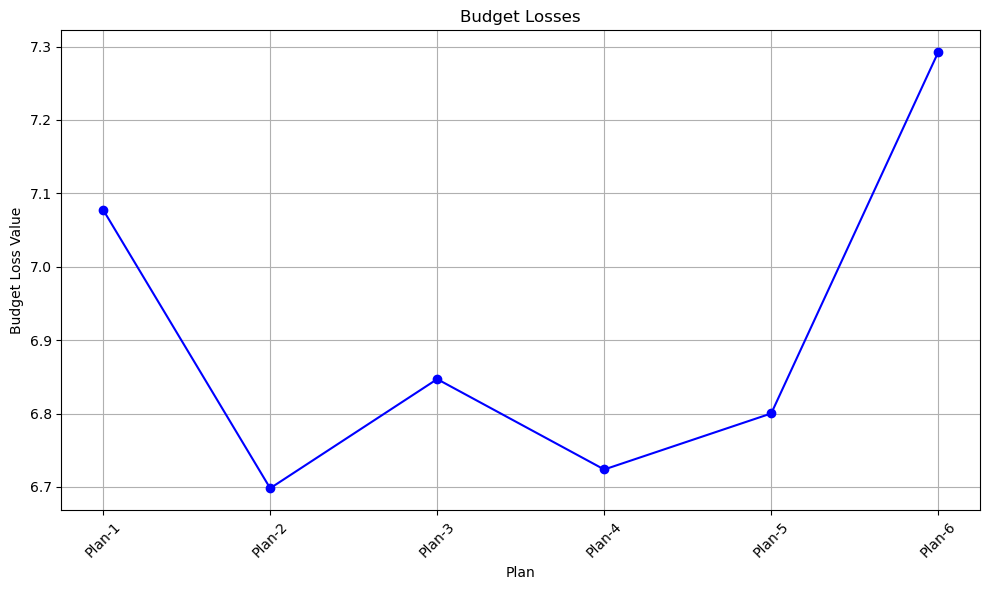

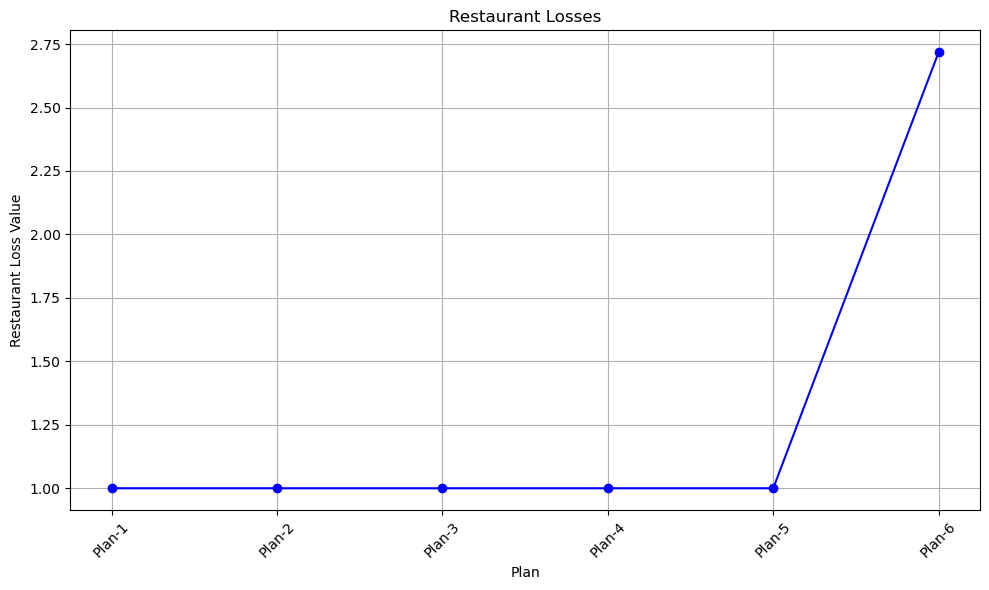

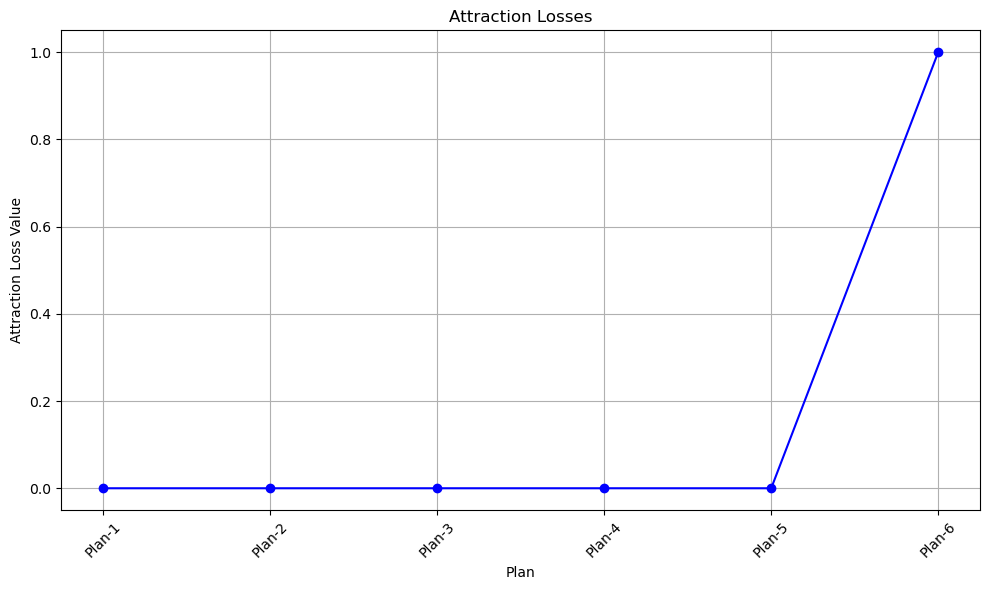

In [62]:
def plot_losses(data, title, ylabel):
    plans = list(data.keys())
    losses = list(data.values())
    plt.figure(figsize=(10, 6))
    plt.plot(plans, losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Plan')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(plans, [f'Plan-{key}' for key in plans], rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot each type of loss
plot_losses(budget_losses, 'Budget Losses', 'Budget Loss Value')
plot_losses(restaurant_losses, 'Restaurant Losses', 'Restaurant Loss Value')
plot_losses(attraction_losses, 'Attraction Losses', 'Attraction Loss Value')

In [63]:
print(local_constraint)

{'house rule': None, 'cuisine': None, 'room type': None, 'transportation': 'no flight'}


In [64]:
class LocalConstraintEvaluator:
    def __init__(self, travel_plans):
        self.data = travel_plans
    
    def evaluate_local_constraints(self, local_constraint):
        # Initialize the result dictionary
        constraint_losses = {}
        
        # Retrieve constraints from the dictionary
        house_rule = local_constraint.get('house rule')
        cuisine = local_constraint.get('cuisine')
        room_type = local_constraint.get('room type')
        transportation = local_constraint.get('transportation')
        
        # Initialize losses
        house_rule_loss = 0
        cuisine_loss = 0
        room_type_loss = 0
        transportation_loss = 0
        
        # Check each plan
        for plan in self.data['plans']:
            plan_id = plan['plan_id']
            
            # For now, house_rule, cuisine, and room_type losses are all set to 0
            # If additional logic is needed for these, you can implement it here

            # Check 'transportation' constraint
            if transportation:
                if transportation == 'no flight':
                    if any('flight' in day['transportation'].lower() for day in plan['days']):
                        transportation_loss = 1
                elif transportation == 'no self-driving':
                    if any('self-driving' in day['transportation'].lower() for day in plan['days']):
                        transportation_loss = 1
            
            # Add the losses to the result dictionary
            constraint_losses[plan_id] = {
                'house_rule_loss': house_rule_loss,
                'cuisine_loss': cuisine_loss,
                'room_type_loss': room_type_loss,
                'transportation_loss': transportation_loss
            }
        
        return constraint_losses


evaluator = LocalConstraintEvaluator(travel_plans)
constraint_losses = evaluator.evaluate_local_constraints(local_constraint)

In [65]:
constraint_losses

{1: {'house_rule_loss': 0,
  'cuisine_loss': 0,
  'room_type_loss': 0,
  'transportation_loss': 0},
 2: {'house_rule_loss': 0,
  'cuisine_loss': 0,
  'room_type_loss': 0,
  'transportation_loss': 0},
 3: {'house_rule_loss': 0,
  'cuisine_loss': 0,
  'room_type_loss': 0,
  'transportation_loss': 0},
 4: {'house_rule_loss': 0,
  'cuisine_loss': 0,
  'room_type_loss': 0,
  'transportation_loss': 0},
 5: {'house_rule_loss': 0,
  'cuisine_loss': 0,
  'room_type_loss': 0,
  'transportation_loss': 0},
 6: {'house_rule_loss': 0,
  'cuisine_loss': 0,
  'room_type_loss': 0,
  'transportation_loss': 1}}

In [66]:
dest = first_row['dest']
print(dest)

Myrtle Beach


In [67]:
# Load the CSV file into a DataFrame
file_path = "database/restaurants/clean_restaurant_2022.csv"
df = pd.read_csv(file_path)

# Filter for restaurants in dst
dest_restaurants = df[df['City'] == dest]

# Calculate the average of the 'Aggregate Rating' column
threshold_rating = round(dest_restaurants['Aggregate Rating'].mean(), 1)
max_rating = dest_restaurants['Aggregate Rating'].max()

print(threshold_rating)
print(max_rating)

2.3
4.6


In [68]:
dest_restaurants

,Unnamed: 0,Name,City,Cuisines,Average Cost,Aggregate Rating
174,174,Exotic India,Myrtle Beach,"Indian, BBQ, Fast Food",81,4.1
271,271,Catfish Charlie's,Myrtle Beach,"Tea, Chinese, Desserts",14,3.3
715,715,d' Curry House,Myrtle Beach,"Tea, Chinese, Desserts, Fast Food",33,3.6
1312,1312,Twigly,Myrtle Beach,"Tea, Bakery, Mediterranean, Seafood",55,4.6
1401,1401,First Eat,Myrtle Beach,"Tea, Mexican, Fast Food",21,4.0
1867,1867,Nagai,Myrtle Beach,"Desserts, Pizza, Mexican, Fast Food, American,...",19,4.3
1896,1896,La Pino'z Pizza,Myrtle Beach,"Cafe, Seafood, Fast Food",14,3.5
2523,2523,Eat Street Express,Myrtle Beach,"Fast Food, Pizza, BBQ, Italian",100,4.0
2791,2791,Punjabi Tadka,Myrtle Beach,"Bakery, BBQ, Fast Food, Chinese, Seafood",73,2.8
2877,2877,Kedarnath Prem Chand Halwai,Myrtle Beach,"Desserts, Tea, Fast Food, American, Mediterran...",61,3.7


In [69]:
class RestaurantRatingsRatio:
    def __init__(self, travel_plans, dest_restaurants, threshold_rating, max_rating, dest):
        self.data = travel_plans
        self.dest_restaurants = dest_restaurants
        self.threshold_rating = threshold_rating
        self.max_rating = max_rating
        self.dest = dest

        # Normalize the dest_restaurants DataFrame restaurant names
        self.dest_restaurants['Name'] = self.dest_restaurants['Name'].str.lower().str.strip()
        self.dest = self.dest.lower().strip()

    def _clean_restaurant_name(self, name):
        """Clean restaurant name by removing the destination city and additional characters."""
        return name.lower().replace(f', {self.dest};', '').strip()

    def calculate_restaurant_rating_ratios(self):
        rating_ratios = {}

        for plan in self.data['plans']:
            plan_id = plan['plan_id']
            restaurants = []

            # Collect all restaurants mentioned in meals
            for day in plan['days']:
                for meal in ['breakfast', 'lunch', 'dinner']:
                    meal_info = day['meals'].get(meal, '')
                    if 'Cost:' in meal_info:
                        restaurant = meal_info.split('Cost: ')[0].strip()
                        if restaurant and restaurant != '-':
                            # Clean restaurant name
                            restaurant_cleaned = self._clean_restaurant_name(restaurant)
                            restaurants.append(restaurant_cleaned)

            # print(f"Plan {plan_id} Restaurants: {restaurants}")  # Debugging print

            # Find ratings for the restaurants in dest_restaurants DataFrame
            if restaurants:
                ratings = []
                for restaurant in restaurants:
                    # Find the rating for the restaurant name
                    rating_row = self.dest_restaurants[self.dest_restaurants['Name'] == restaurant]
                    if not rating_row.empty:
                        rating_value = rating_row['Aggregate Rating'].values[0]
                        # print(f"Found rating for {restaurant}: {rating_value}")  # Debugging print
                        ratings.append(rating_value)
                    else:
                        continue
                        # print(f"No rating found for {restaurant}")  # Debugging print

                # Compute average rating if any restaurants were found
                if ratings:
                    avg_rating = sum(ratings) / len(ratings)
                    # Calculate the ratio as per the formula
                    rating_ratio = (avg_rating - self.threshold_rating) / (self.max_rating - self.threshold_rating)
                else:
                    rating_ratio = None  # No matching ratings found
            else:
                rating_ratio = None  # No restaurants in this plan

            rating_ratios[plan_id] = rating_ratio

        return rating_ratios

ratios = RestaurantRatingsRatio(travel_plans, dest_restaurants, threshold_rating, max_rating, dest)
restaurant_rating_ratios = ratios.calculate_restaurant_rating_ratios()

print(restaurant_rating_ratios)

{1: 0.6884057971014494, 2: 0.8405797101449277, 3: 0.39130434782608714, 4: 0.8152173913043479, 5: 0.7329192546583855, 6: 0.6956521739130436}


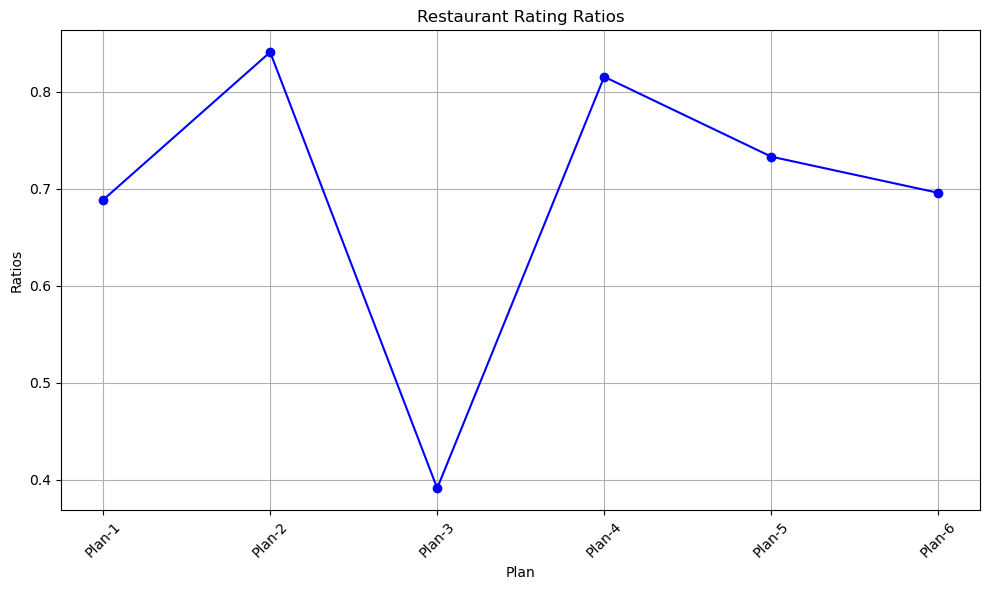

In [70]:
def plot_ratios(data, title, ylabel):
    
    plans = list(data.keys())
    ratios = list(data.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(plans, ratios, marker='o', linestyle='-', color='b')
    plt.xlabel('Plans')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(plans, [f'Plan-{key}' for key in plans], rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_losses(restaurant_rating_ratios, 'Restaurant Rating Ratios', 'Ratios')